<a href="https://colab.research.google.com/github/Carvas91/PyTroch/blob/main/L2_regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
from IPython import display
import matplotlib.pyplot as plt
display.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader, TensorDataset

<ipython-input-1-f07e19ccbd50>:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
iris = sns.load_dataset('iris')

data = torch.tensor(iris[iris.columns[0:4]].values).float()

labels = torch.zeros(len(data),dtype=torch.long)

labels[iris.species == 'versicolor'] = 1
labels[iris.species == 'virginica'] = 2

In [3]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

trainloader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)
testloader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [4]:
def createModel(L2Lambda):
  ANNiris = nn.Sequential(
      nn.Linear(4,64),
      nn.ReLU(),

      nn.Linear(64,64),
      nn.ReLU(),
      nn.Linear(64,3)
  )

  lossfun = nn.CrossEntropyLoss()

  optimizer = torch.optim.SGD(ANNiris.parameters(), lr=0.1, weight_decay=L2Lambda)
  return ANNiris, lossfun, optimizer


In [5]:
epochs = 1000

def trainModel(ANNiris, lossfun, optimizer):
  trainAcc = []
  testAcc = []
  losses = []

  for i in range(epochs):
    batchAcc = []
    batchloss = []

    for X,y in trainloader:
      yHat = ANNiris(X)
      loss = lossfun(yHat, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchAcc.append(torch.mean((torch.argmax(yHat, axis=1)==y).float()).item()*100)
      batchloss.append(loss.item())

    trainAcc.append(np.mean(batchAcc))
    losses.append(np.mean(batchloss))

    ANNiris.eval()
    X,y = next(iter(testloader))
    predlabels = torch.argmax(ANNiris(X),axis=1)
    testAcc.append(torch.mean((predlabels==y).float()).item()*100)

    ANNiris.train()

  return trainAcc, testAcc, losses



In [6]:
L2Lambda = 0.01

ANNiris, lossfun, optimizer = createModel(L2Lambda)

trainAcc, testAcc, losses = trainModel(ANNiris, lossfun, optimizer)

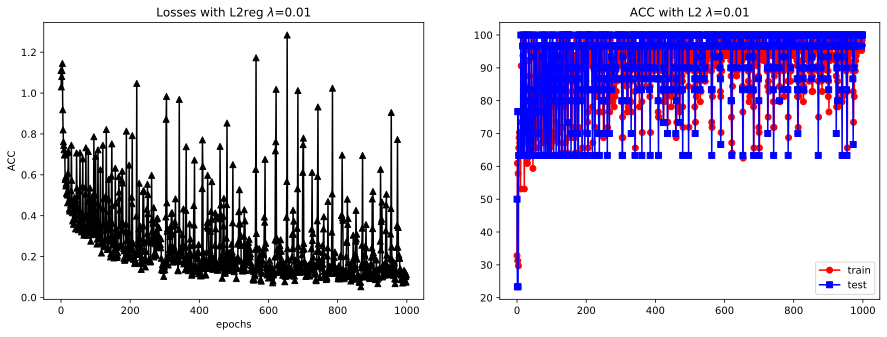

In [7]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(losses, 'k^-')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[0].set_title("Losses with L2reg $\lambda$=" +str(L2Lambda))

ax[1].plot(trainAcc, 'ro-')
ax[1].plot(testAcc, 'bs-')
ax[1].set_title('ACC with L2 $\lambda$=' +str(L2Lambda))
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('ACC')
ax[1].legend(['train','test'])

plt.show()

In [11]:
def smooth(x,k):
  return np.convolve(x, np.ones(k)/k, mode='same')

In [17]:
L2Lambdas = np.linspace(0,.1,5)
accResultsTrain = np.zeros((epochs,len(L2Lambdas)))
accResultsTest = np.zeros((epochs,len(L2Lambdas)))

for i in range(len(L2Lambdas)):
  ANNiris, lossfun, optimizer = createModel(L2Lambdas[i])
  trainAcc, testAcc, losses = trainModel(ANNiris, lossfun, optimizer)

  accResultsTrain[:,i] = smooth(trainAcc, 10)
  accResultsTest[:,i] = smooth(testAcc, 10)


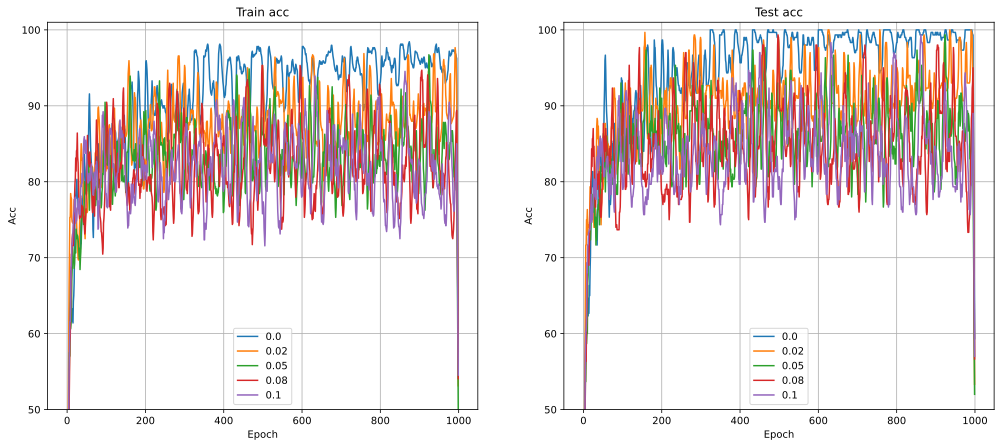

In [18]:
fig, ax = plt.subplots(1,2,figsize=(17,7))
ax[0].plot(accResultsTrain)
ax[0].set_title("Train acc")

ax[1].plot(accResultsTest)
ax[1].set_title("Test acc")

leglabels = [np.round(i,2) for i in L2Lambdas]

for i in range(2):
  ax[i].legend(leglabels)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Acc')
  ax[i].set_ylim([50,101])
  ax[i].grid()

plt.show()
